In [2]:
import numpy as np
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import shapely.geometry as sg
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json
import utils.toolshelf as t
import LagrangianDEMdifferencing.utils.lagrange as lagrange
from random import sample

import fiona

warnings.filterwarnings('ignore')
%matplotlib inline

ModuleNotFoundError: No module named 'utils'

In [3]:
####################### SET PARAMETERS #################

In [5]:
# # Select predetermined track (2 digit cycle number)
site = "ross1"
cycle = '12'

# Data access options
# (-1: Skip altogether, 0: process fresh, 1: load from geojson, 2: load from csv)
accessType = 0

#input options
# resolution (recommended 20.0)
# "len" and "res" (will be equal)
res = 10.0
cnf = 2

#output options
# Save flag 06 (0: dont save, 1: save as geojson (slow but everything works), 
# 2: save as csv (faster but nothing works))
sFlag06 = 0

# Save flag melange (0: dont save, 1: save)
sFlagm = 0

# Save flag 03 (0: dont save, 1: save as geojson)
sFlag03 = 0

# File locations
shpPath = f"../shapes/{site}/{site}_{cycle}.geojson"
#shpPath = f"../shapes/{site}_2019-09-03_04.geojson"
#shpPath = f"../shapes/{site}.geojson"

datPath = f"../data/"
figPath = f"../figs/{site}/"
filename03 = f"{datPath}{site}_ATL03_cyc{cycle}_res{int(res)}"
filename06 = f"{datPath}{site}_ATL06_cyc{cycle}_res{int(res)}"
filename06Load = f"{datPath}{site}_res{int(res)}/{site}_ATL06_cyc{cycle}_res{int(res)}"
filenameMel = f"{datPath}{site}/{site}_mel_cyc{cycle}_res{int(res)}"

In [6]:
filenameMel

'../data/ross1/ross1_mel_cyc12_res10'

In [7]:
########################### BEGIN ####################

In [8]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

In [9]:
# gt dictionary
global gtDict, revgtDict, geoidDefault
gtDict = {"gt1l": 10, "gt1r": 20, "gt2l": 30, "gt2r": 40, "gt3l": 50, "gt3r": 60}
revgtDict = {10: "gt1l", 20: "gt1r", 30: "gt2l", 40: "gt2r", 50: "gt3l", 60: "gt3r"}
geoidDefaultDict = {'ross1': -55.5, 'filchnerF1': -14.45734}
geoidDefault = geoidDefaultDict[site]
melangeCutoffDict = {'ross1': 30, 'filchnerF1': 60, 'larsenC': 20, 'ninnis': 10}
min_photonDict = {'ross1': 200, 'filchnerF1': 200, 'larsenC': 200}

'''
File Naming Conventions
ATL[xx]_[yyyymmdd][hhmmss]_[tttt][cc][nn]_[vvv]_[rr].h5
xx : ATLAS product number
yyyymmdd : year, month and day of data acquisition
hhmmss : start time, hour, minute, and second of data acquisition
tttt : Reference Ground Track (RGT, ranges from 1–1387)
cc : Orbital Cycle (91-day period)
nn : Granule number (ranges from 1–14)
vvv : data version number
rr : data release number
'''

# Import granule id, 
def unpackGranuleID(gid):
    #global shortName, dat, tim, rgt, cycle, granuleNumber, version, release
    granID = gid[:]
    gid = gid.split('_')
    shortName = f'{gid[0]}'
    dat = f'{gid[1][0:4]}-{gid[1][4:6]}-{gid[1][6:8]}'
    tim = f'{gid[1][8:10]}:{gid[1][10:12]}:{gid[1][12:14]}'
    rgt = int(f'{gid[2][0:4]}')
    cycle = int(f'{gid[2][4:6]}')
    granuleNumber = int(f'{gid[2][6:8]}')
    version = int(f'{gid[3]}')
    release = int(f'{gid[4][0:2]}')
    return {"shortName": shortName, "date": dat, "time": tim, 
            "rgt": rgt, "cycle": cycle, "granuleNumber": granuleNumber, 
            "version": version, "release": release, "granuleID": granID}

# Get a datetime formatted for earthdata cmr search from geodataframe timestamp
def getDateTime(timestp):
    dat, tim = timestp.date(), timestp.time().strftime("%H:%M:%S")
    return f"{dat}T{tim}Z"

def displayInfo(gdf):
    print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
    print("Beams: {}".format([revgtDict[b] for b in list(gdf['gt'].unique())]))
    print("Cycles: {}".format(gdf["cycle"].unique()))
    print("Received {} elevations".format(gdf.shape[0]))
    print(f"Across {3*(len(np.unique(gdf.loc[:, 'rgt'])) + len(np.unique(gdf.loc[:, 'cycle'])))} strong tracks")
    # Exception here is only necessary when importing csv's
    try: print(f"Date range {gdf.index.min().date()} to {gdf.index.max().date()}")
    except: print(f"Date range {datetime.strptime(gdf.index.min()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}" 
        f" to {datetime.strptime(gdf.index.max()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}")
    print(f"Vertical range {gdf.h_mean.min()}m to {gdf.h_mean.max()}m")
    return

def display03Info(gdf):
    print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
    #print("Beams: {}".format([revgtDict[b] for b in list(atl06_sr['gt'].unique())]))
    print("Spots: {}".format(gdf["spot"].unique()))
    print("Cycles: {}".format(gdf["cycle"].unique()))
    print("Received {} elevations".format(gdf.shape[0]))
    print(f"Across {3*(len(np.unique(gdf.loc[:, 'rgt'])) + len(np.unique(gdf.loc[:, 'cycle'])))} strong tracks")
    # Exception here is only necessary when importing csv's
    try: print(f"Date range {gdf.index.min().date()} to {gdf.index.max().date()}")
    except: print(f"Date range {datetime.strptime(gdf.index.min()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}" 
        f" to {datetime.strptime(gdf.index.max()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}")
    return

def getTrackList(gdf, min_photons=200, print_lens=False, verbose=True):
    rgtAll = atl06_sr["rgt"].unique()
    gtAll = atl06_sr['gt'].unique()
    cycleAll = atl06_sr["cycle"].unique()
    lens = []
    tracks=[]

    for cyc in cycleAll:
        #t = atl06_sr[atl06_sr.cycle==cyc]
        for r in rgtAll:
            #t = t[t.rgt==r]
            for g in gtAll:
                t = atl06_sr[(atl06_sr.cycle==cyc)*(atl06_sr.rgt==r)*(atl06_sr.loc[:, 'gt']==g)]
                if len(t)>min_photons:
                    tracks.append((cyc, r, revgtDict[g]))
                    lens.append(len(t))
    if print_lens: print(lens)
    if verbose:
        print(f'Finding tracks with minimum of {min_photons} photons')
        print(f'{len(lens)} found')
    return tracks

def getTrack(dat, trackInfo):
    cycle, rgt, gt = trackInfo[0], trackInfo[1], gtDict[trackInfo[2]]
    track = dat[(dat.rgt==rgt)*(dat.cycle==cycle)*(dat.loc[:, 'gt']==gt)]
    return track, cycle, rgt, gt

def geoCorrect(dat):
    # Geo correct atl03 data
    return dat['height']-dat['geoid']

# Plotting stuff
def plot06(track, save=False, titl='ATL06 Data', xlab='S-N latitude', ylab='Elevation above geoid (m)',
          xl=None, yl=None):
    try:
        fig, ax = plt.subplots(figsize=[15, 3])

        x = (track['distance']-track['distance'][0])/1000
        x = track.geometry.y
        y = track.h_mean
        if not isSeaward:
            print("Track should be reversed to seaward orientation")
            #x = (track['distance']-(track['distance'][-1]))/1000
        ax.plot(x, y, '-', color='orange', linewidth=2.5, label='ATL06-SR')

        x = (mTrack['distance']-track['distance'][0])/1000
        x = mTrack.geometry.y
        y = mTrack.h_mean
        ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
        ax.set_title(titl)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.set_ylim(yl)
        ax.set_xlim(xl)
        ax.legend(loc=4, frameon=False)
        info = f'ICESat-2 track {rgt}-{revgtDict[gt]}'
        plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
                 transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
        if save:
            plt.savefig(f'{figPath}melange/{site}_cyc{cycle}_rgt{rgt}-{revgtDict[gt][-2:]}_res{res}_mel.png', 
                        dpi=150, bbox_inches='tight')
            
    except: print(f"something went wrong with this track")
    
#Save elevations
def saveMelange(dat):
    datReduced = dat.loc[:, ['cycle', 'rgt', 'spot', 'h_mean', 'geometry']]
    datReduced.to_file(f"{filenameMel}.geojson", driver='GeoJSON')
    return



In [10]:
# Read in EPSG:3031 shapefile and convert to EPSG:4326
shpFile = gpd.read_file(shpPath)
shpFile.crs = 'EPSG:3031'
target_epsg = 'EPSG:4326'
shpDF = shpFile.to_crs(target_epsg)
region = sliderule.toregion(shpDF)["poly"]
#transformed_gdf.to_file(f"test.geojson", driver='GeoJSON') 

DriverError: ../shapes/ross1/ross1_12.geojson: No such file or directory

In [11]:
parms = {
    "poly": region,
    "srt": 0,
    "len": res*2,
    "res": res,
    "cnf": cnf,
    "maxi": 6,
    "ats": 5.0,
    "cnt": 5,
    "H_min_win": 3.0,
    "sigma_r_max": 5.0,
    "cycle": cycle
}

NameError: name 'region' is not defined

In [10]:
%%time
if accessType == 0:
    print('Processing new ATL06-SR dataset')

    # Request ATL06 Data
    print('Downloading all available data')
    atl06_sr = icesat2.atl06p(parms, "nsidc-s3")
    atl06_sr = atl06_sr[(atl06_sr.spot==2)+(atl06_sr.spot==4)+(atl06_sr.spot==6)]

    # Display Statistics
    displayInfo(atl06_sr)
    insufficientDataCache=[]

    # Save all data
    if sFlag06==1:
        # save geodataframe as geojson
        print(f'Saving file as geojson named {filename06}.geojson')
        atl06_sr.to_file(f"{filename06}.geojson", driver='GeoJSON')
    elif sFlag06==2:
        # Save geodataframe as csv
        print(f'Saving file as csv named {filename06}.csv')
        atl06_sr.to_csv(f"{filename06}.csv")

elif accessType==1:
    #load from geojson
    print('Downloading atl06-SR data upload from .geojson file')
    atl06_sr = gpd.read_file(f"{filename06Load}.geojson").set_index('time')
    displayInfo(atl06_sr)
elif accessType==2:
    # Load from csv (everything is a string)
    print('Downloading atl06-SR data upload from .csv file')
    atl06_sr = gpd.read_file(f"{filename06Load}.csv").set_index('time')
    displayInfo(atl06_sr)
elif accessType==-1:
    print('skipping data download altogether')

Processing new ATL06-SR dataset
Reference Ground Tracks: [ 109  170  231  375  436  612  673  695  734  878  993 1054 1115 1320]
Beams: ['gt3l', 'gt2l', 'gt1l', 'gt3r', 'gt2r', 'gt1r']
Cycles: [13]
Received 12941 elevations
Across 45 strong tracks
Date range 2021-09-29 to 2021-12-17
Vertical range -3.8938297041809915m to 75.52354814557387m
CPU times: user 709 ms, sys: 32 ms, total: 741 ms
Wall time: 19 s


In [11]:
#Triple check this cell

# separate all good tracks and put them into a list
trackList = getTrackList(atl06_sr, print_lens=True)#, min_photons=min_photonDict[site])
ss_atl06_sr = pd.concat([getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList])

#Geoid and outliers
# for ross limits good limits are
print('correcting for geoid, scraping outliers')
ss_atl06_sr.h_mean -= geoidDefault
# filchner1 -5, 100
ss_atl06_sr = ss_atl06_sr[(ss_atl06_sr.h_mean<100)*(ss_atl06_sr.h_mean>-5)]

melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<melangeCutoffDict[site]]
ss_atl06_sr_list = [getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
displayInfo(ss_atl06_sr)


if sFlagm==1: saveMelange(melange_sr)

[339, 409, 481, 649, 638, 623, 545, 487, 399, 521, 573, 609, 288, 311, 238, 613, 579, 525, 275, 268, 359, 441, 457, 525, 586, 201]
Finding tracks with minimum of 200 photons
26 found
correcting for geoid, scraping outliers
Reference Ground Tracks: [ 109  170  231  375  436  612  673  734  878 1054 1115]
Beams: ['gt3l', 'gt2l', 'gt1l', 'gt3r', 'gt2r', 'gt1r']
Cycles: [13]
Received 11939 elevations
Across 36 strong tracks
Date range 2021-09-29 to 2021-12-04
Vertical range 10.56351029581901m to 89.98088814557387m


In [25]:
# Plot every 40 points from tracklist to not slow down the notebook
projection = 'South'
max_plot_points = atl06_sr.shape[0]
m = ipysliderule.leaflet(projection, zoom=10, scroll_wheel_zoom=True)
m.GeoData(ss_atl06_sr.iloc[::40], column_name='h_mean', cmap='viridis', max_plot_points=max_plot_points)
#m.GeoData(
display.display(m.map)

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [26]:
# Plot every 40 points from tracklist to not slow down the notebook
projection = 'South'
max_plot_points = atl06_sr.shape[0]
cpoint = atl06_sr.iloc[1000].geometry
m = ipysliderule.leaflet(projection, center=[cpoint.x, cpoint.y], zoom=10, scroll_wheel_zoom=True)
m.GeoData(melange_sr.iloc[::40], column_name='h_mean', cmap='viridis', max_plot_points=max_plot_points)
display.display(m.map)

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [29]:
ss_atl06_sr.h_mean.max()

89.53870887400568

Randomly selected track: Site filchnerF1, 2021-10-17, Cycle 13, RGT 375, Beam gt3r
Contains 521 photons
Track should be reversed to seaward orientation


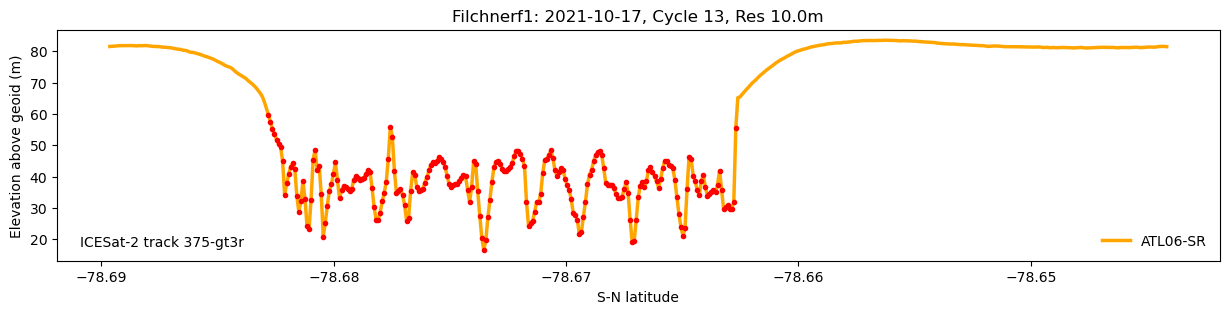

In [12]:
# Plot method (0: random track, 1: everything)
plotMethod = 0

# plot settings
yl = None#[0, 92]
xl=None

if plotMethod==0:
    trackInfo = sample(trackList, 1)[0]
    track, cycle, rgt, gt = getTrack(ss_atl06_sr, trackInfo)
    mTrack, cycle, rgt, gt = getTrack(melange_sr, trackInfo)

    try: 
        isSeaward = track.geometry.y.iloc[0]< track.geometry.y.iloc[10]
        dat = track.index.min().date()
        print(f"Randomly selected track: Site {site}, {dat}, Cycle {cycle}, RGT {rgt}, Beam {revgtDict[gt]}")
        print(f"Contains {len(track)} photons")
    except: 
        print(f"Exception: Random track Site {site}, {dat}, Cycle {cycle}, RGT {rgt}, Beam {revgtDict[gt]} does not contain enough data")
        if rgt not in insufficientDataCache: insufficientDataCache.append([rgt, revgtDict[gt]])
        print(f"Insufficient data cache: {insufficientDataCache}")
        
    titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
    xlab = 'S-N latitude'
    ylab = 'Elevation above geoid (m)'
    plot06(track, save=False, titl=titl, xlab=xlab, ylab=ylab, yl=yl)
    
elif plotMethod==1:
    count=0
    
    for t in trackList:
        print(f"{count}, {t}")
        count+=1
        
        track, cycle, rgt, gt = getTrack(ss_atl06_sr, t)
        mTrack, cycle, rgt, gt = getTrack(melange_sr, t)
        dat = track.index.min().date()
        
        
        titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
        xlab = 'S-N latitude'
        ylab = 'Elevation above geoid (m)'
        plot06(track, save=True, titl=titl, xlab=xlab, ylab=ylab, yl=yl)
        #plt.axhline(y=60)

In [28]:
getTrack(ss_atl06_sr, trackInfo)[1:]

(12, 609, 50)

In [15]:
%%time
#EarthData query to acquire granule IDs

earthdata.set_max_resources=2000
granules_list = earthdata.cmr(short_name='ATL03', polygon=region, version='006', time_start=getDateTime(atl06_sr.index.min()), 
    time_end=getDateTime(atl06_sr.index.max()), return_metadata=True)
granMD = pd.DataFrame([unpackGranuleID(gran) for gran in granules_list[0]]).set_index('granuleID')
granule_sizes = [float(granule['granule_size']) for granule in granules_list[1]]
print(f"{len(granule_sizes)} granules with average size {np.mean(granule_sizes)/1e6} MB, totalling {np.sum(granule_sizes)/1e6/1000} GB")

25 granules with average size 2503.8212773999953 MB, totalling 62.595531934999876 GB
CPU times: user 142 ms, sys: 436 µs, total: 143 ms
Wall time: 1.84 s


In [16]:
rgt, gt = 375, 40

In [17]:
#Choose the track from earlier (beam not selected yet)


trackID = granMD[(granMD.cycle==cycle)*(granMD.rgt==rgt)].index[0]
tr = int(revgtDict[gt][2])
pair = 0 if revgtDict[gt][3]=="l" else 1
trackID

trackInfo = (cycle, rgt, revgtDict[gt])
track, cycle, rgt, gt = getTrack(ss_atl06_sr, trackInfo)
mTrack, cycle, rgt, gt = getTrack(melange_sr, trackInfo)

In [18]:
%%time
# ATL03 Processing

##### Set ATL03 sp parameters ##############################
parms = {
    "poly": region,
    "srt": 0,
    "len": res*2,
    "res": res,
    # identify ground track
    "track": tr,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True,
    # all photons
    "cnf": 2,
    "cnt": 5,
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid"],
    "atl03_ph_fields": ["delta_time"],
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    #"yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=100), 
}

#Have a list of only one granule
gdf = icesat2.atl03sp(parms, resources=[trackID])
atl03_yapc = gdf[gdf.pair==pair]

# Display Statistics
display03Info(atl03_yapc)

if sFlag03==1:
    print(f'Saving file as geojson named {filename03}.geojson')
    atl03_yapc.to_file(f"{filename03}.geojson", driver='GeoJSON')

Reference Ground Tracks: [375]
Spots: [4]
Cycles: [13]
Received 35223 elevations
Across 6 strong tracks
Date range 2021-10-17 to 2021-10-17
CPU times: user 8.08 s, sys: 224 ms, total: 8.3 s
Wall time: 9.74 s


In [51]:
titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
xlab = 'S-N latitude'
ylab = 'Height above geoid (m)'
yl = [-5, 60]

mean geoid height -14.641403198242188 m
Track should be reversed to seaward orientation


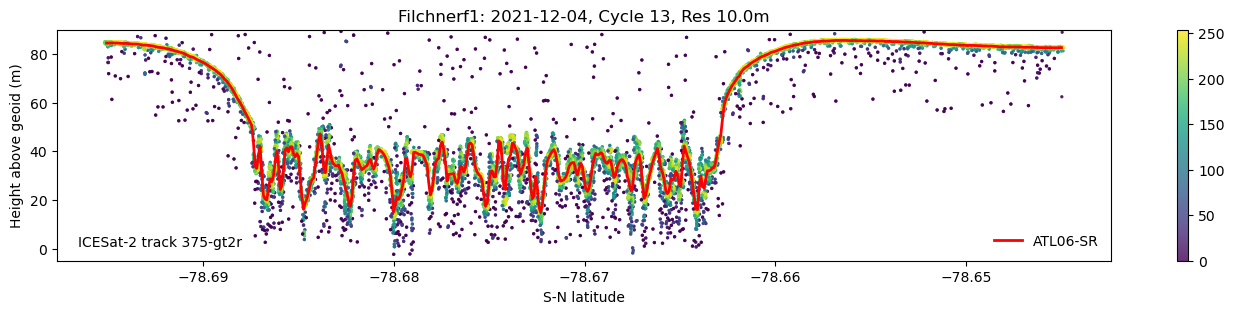

In [77]:
fig, ax = plt.subplots(figsize=[17, 3])
avgGC = np.mean(atl03_yapc.geoid)
print(f'mean geoid height {avgGC} m')
x = atl03_yapc['geometry'].y
y = atl03_yapc.height-avgGC
c = atl03_yapc.yapc_score
plt.scatter(x, y, c=c, s=2, alpha=0.8)#, label='ATL03-YAPC')
x = track['geometry'].y
y = track.h_mean
if not isSeaward:
    print("Track should be reversed to seaward orientation")
    #x = (track['distance']-(track['distance'][-1]))/1000
ax.plot(x, y, '-', color='red', linewidth=2, label='ATL06-SR')
ax.set_title(titl)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
plt.ylim(yl)
#plt.xlim([-1, 14])
ax.legend(loc=4, frameon=False)
info = f'ICESat-2 track {rgt}-{revgtDict[gt]}'
plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
         transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
plt.colorbar()
plt.savefig(f'{figPath}yapc/{site}_cyc{cycle}_rgt{rgt}-{revgtDict[gt][-2:]}_res{res}_yapc.png', dpi=150, bbox_inches='tight')

In [32]:
badTracks = [(16, 1371, 'gt2l')]

pytmd, a few meters

mean dynamic topography, 1.5 m

advection

REMA strips s79 w168 and s27 w169

In [26]:
titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
xlab = 'S-N latitude'
ylab = 'Height above geoid (m)'
yl = [-5, 90]
xl = None#[-78.78, -78.72]
xw = -78.696+78.66
right = -78.658
xl = [right+xw, right]
#xl = [-78.66, -78.696]

mean geoid height -14.641413688659668 m
Track should be reversed to seaward orientation


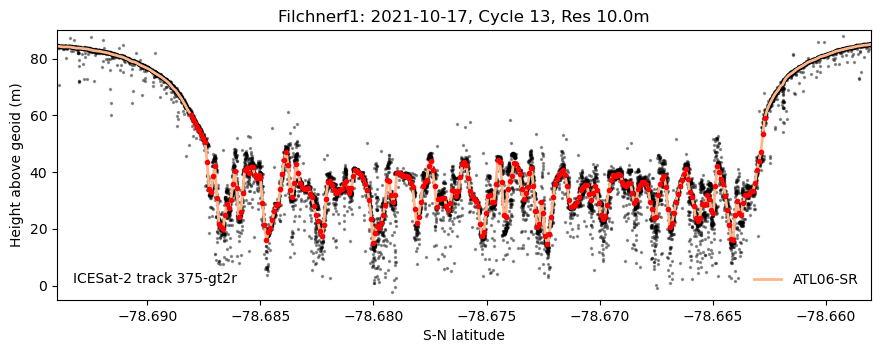

In [27]:
fig, ax = plt.subplots(figsize=[10.5, 3.5])
avgGC = np.mean(atl03_yapc.geoid)
print(f'mean geoid height {avgGC} m')
x = atl03_yapc['geometry'].y
y = atl03_yapc.height-avgGC
c = atl03_yapc.yapc_score
plt.scatter(x, y, color='black', s=2, alpha=0.2)#, label='ATL03-YAPC')
x = track['geometry'].y
y = track.h_mean
if not isSeaward:
    print("Track should be reversed to seaward orientation")
    #x = (track['distance']-(track['distance'][-1]))/1000
#ax.plot(x, y, '-', color='#8a8cff', linewidth=2, label='ATL06-SR')
ax.plot(x, y, '-', color='#ffb58a', linewidth=2, label='ATL06-SR')

x = (mTrack['distance']-track['distance'][0])/1000
x = mTrack.geometry.y
y = mTrack.h_mean
ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
ax.set_title(titl)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
plt.ylim(yl)
plt.xlim(xl)
ax.legend(loc=4, frameon=False)
info = f'ICESat-2 track {rgt}-{revgtDict[gt]}'
plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
         transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
#plt.colorbar()
plt.savefig(f'{figPath}yapc/{site}_cyc{cycle}_rgt{rgt}-{revgtDict[gt][-2:]}_res{res}_yapc.png', dpi=150, bbox_inches='tight')

